# **DISTIL Installation**

In [1]:
!git clone https://github.com/decile-team/distil.git
!git clone https://github.com/decile-team/datasets.git
!pip install apricot-select
%cd distil

Cloning into 'distil'...
remote: Enumerating objects: 2310, done.
remote: Counting objects: 100% (230/230), done.
remote: Compressing objects: 100% (170/170), done.
remote: Total 2310 (delta 115), reused 112 (delta 60), pack-reused 2080
Receiving objects: 100% (2310/2310), 14.98 MiB | 19.59 MiB/s, done.
Resolving deltas: 100% (1418/1418), done.
Cloning into 'datasets'...
remote: Enumerating objects: 16, done.
remote: Counting objects: 100% (16/16), done.
remote: Compressing objects: 100% (13/13), done.
remote: Total 16 (delta 3), reused 12 (delta 2), pack-reused 0
Unpacking objects: 100% (16/16), done.
     |████████████████████████████████| 163kB 6.4MB/s 
  Created wheel for apricot-select: filename=apricot_select-0.6.1-cp37-none-any.whl size=48789 sha256=fe28e61a9abe6f9f1405a7e798e2927ea1c70cef6c08cdf168f80e81b3980aa3
  Stored in directory: /root/.cache/pip/wheels/27/53/c1/67fd7b8bd5be9d506fdac6bb9b73b5c69734da8210833998fa
Successfully built apricot-select
/content/distil


# **Imports**

In [3]:
import numpy as np
import os
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
import torch.nn.functional as F
from torch import nn
from torchvision import transforms
import torch
import torch.optim as optim
from torch.autograd import Variable
import sys
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from copy import deepcopy

from distil.active_learning_strategies import GLISTER, BADGE, EntropySampling, RandomSampling, SubmodSampling
from distil.utils.data_handler import DataHandler_Points
from distil.utils.models.simple_net import TwoLayerNet
from distil.utils.train_helper import data_train

from matplotlib import pyplot as plt
from google.colab import drive

/usr/local/lib/python3.7/dist-packages/numba/np/ufunc/parallel.py:363: NumbaWarning: The TBB threading layer requires TBB version 2019.5 or later i.e., TBB_INTERFACE_VERSION >= 11005. Found TBB_INTERFACE_VERSION = 9107. The TBB threading layer is disabled.
  warnings.warn(problem)


# **Data, Model & Directory Configuration**

In [4]:
def libsvm_file_load(path,dim, save_data=False):
    data = []
    target = []
    with open(path) as fp:
       line = fp.readline()
       while line:
        temp = [i for i in line.strip().split(" ")]
        target.append(int(float(temp[0]))) # Class Number. # Not assumed to be in (0, K-1)
        temp_data = [0]*dim
        
        for i in temp[1:]:
            ind,val = i.split(':')
            temp_data[int(ind)-1] = float(val)
        data.append(temp_data)
        line = fp.readline()
    X_data = np.array(data,dtype=np.float32)
    Y_label = np.array(target)
    if save_data:
        # Save the numpy files to the folder where they come from
        data_np_path = path + '.data.npy'
        target_np_path = path + '.label.npy'
        np.save(data_np_path, X_data)
        np.save(target_np_path, Y_label)
    return (X_data, Y_label)

    
trn_file = '../datasets/satimage/satimage.scale.trn'
val_file = '../datasets/satimage/satimage.scale.val'
tst_file = '../datasets/satimage/satimage.scale.tst'
data_dims = 36
nclasses = 6

x_trn, y_trn = libsvm_file_load(trn_file, dim=data_dims)
x_val, y_val = libsvm_file_load(val_file, dim=data_dims)
x_tst, y_tst = libsvm_file_load(tst_file, dim=data_dims)

y_trn -= 1  # First Class should be zero
y_val -= 1
y_tst -= 1  # First Class should be zero

sc = StandardScaler()
x_trn = sc.fit_transform(x_trn)
x_val = sc.transform(x_val)
x_tst = sc.transform(x_tst)

def init_weights(m):
    if type(m) == nn.Linear:
        torch.nn.init.xavier_uniform_(m.weight)
        m.bias.data.fill_(0.01)

In [5]:
X_unlabeled = deepcopy(x_trn)
y_unlabeled = deepcopy(y_trn)
X_test = deepcopy(x_tst)
y_test = deepcopy(y_tst)

nSamps, dim = np.shape(X_unlabeled)

np.random.seed(42)
start_idxs = np.random.choice(nSamps, size=int(0.01*nSamps), replace=False)

X_tr = X_unlabeled[start_idxs]
X_unlabeled = np.delete(X_unlabeled, start_idxs, axis = 0)

y_tr = y_unlabeled[start_idxs]
y_unlabeled = np.delete(y_unlabeled, start_idxs, axis = 0)

n_rounds = 10    ##Number of rounds to run ac
budget = int(0.01*x_trn.shape[0]) 
handler = DataHandler_Points

net = TwoLayerNet(data_dims, nclasses, 40)
net.apply(init_weights)

TwoLayerNet(
  (linear1): Linear(in_features=36, out_features=40, bias=True)
  (linear2): Linear(in_features=40, out_features=6, bias=True)
)

In [6]:
#Model Directory
base_dir = "/content/satimage/"
os.makedirs(base_dir, exist_ok = True)
model_directory = os.path.join(base_dir, 'base_model.pth')

# **Initial Model Training**

In [7]:
args = {'n_epoch':500, 'lr':float(0.01),'batch_size':16, 'max_accuracy':0.99, 'window_size':20} 
dt = data_train(X_tr, y_tr, net, handler, args)
clf = dt.train()
torch.save(clf.state_dict(), model_directory)

Training..
Epoch: 49 Training accuracy: 1.0


# **Load Base Model**

In [8]:
net.load_state_dict(torch.load(model_directory))
clf = net

# **Random**
This strategy is often used as a baseline, where we pick a set of unlabled points randomly. Here we create a instance of distil.active_learning_strategies.random_sampling.RandomSampling by passig following parameters:

**X (Numpy array)** – Features of the labled set of points

**Y (Numpy array)** – Lables of the labled set of points

**unlabeled_x (Numpy array)** – Features of the unlabled set of points

**net (class object)** – Model architecture used for training. Could be instance of models defined in distil.utils.models or something similar.

**handler (class object)** – It should be a subclass of torch.utils.data.Dataset i.e, have __getitem__ and __len__ methods implemented, so that is could be passed to pytorch DataLoader.Could be instance of handlers defined in distil.utils.DataHandler or something similar.

**nclasses (int)** – No. of classes in tha dataset

**args (dictionary)**– This dictionary should have ‘batch_size’ as a key. 'batch_size' should be such that one can exploit the benefits of tensorization while honouring the resourse constraits. This ‘batch_size’ therefore can be different than the one used for training.

We initally pass None for X,Y and unlabeled_x. Later we update using update functions of training class and RandomSampling class. 

In [9]:
#Initializing Strategy Class
strategy_args = {'batch_size' : 16, 'lr':float(0.01)}
strategy = RandomSampling(X_tr, y_tr, X_unlabeled, net, handler, nclasses, strategy_args)

#Initial Training
args = {'n_epoch':500, 'lr':float(0.01),'batch_size':16, 'max_accuracy':0.99, 'window_size':20} 
dt = data_train(X_tr, y_tr, clf, handler, args)

#Updating the trained model in strategy class
strategy.update_model(clf)

# y_pred = strategy.predict(X_test).numpy()
acc = np.zeros(n_rounds)
acc[0] = dt.get_acc_on_set(X_test, y_test)
print('Initial Testing accuracy:', round(acc[0]*100, 2), flush=True)

##User Controlled Loop
for rd in range(1, n_rounds):
    print('-------------------------------------------------')
    print('Round', rd) 
    print('-------------------------------------------------')

    #Using select function for getting next set of data points
    idx = strategy.select(budget)

    #Saving state of model, since labeling new points might take time
    strategy.save_state('./state.pkl')

    #Adding new points to training set
    X_tr = np.concatenate((X_tr, X_unlabeled[idx]), axis=0)
    X_unlabeled = np.delete(X_unlabeled, idx, axis = 0)

    #Human In Loop, Assuming user adds new labels here
    y_tr = np.concatenate((y_tr, y_unlabeled[idx]), axis = 0)
    y_unlabeled = np.delete(y_unlabeled, idx, axis = 0)
    print('Number of training points -',X_tr.shape[0])

    #Reload state and start training
    strategy.load_state('./state.pkl')
    strategy.update_data(X_tr, y_tr, X_unlabeled)
    dt.update_data(X_tr, y_tr)

    clf = dt.train()
    strategy.update_model(clf)
    acc[rd] = dt.get_acc_on_set(X_test, y_test)
    print('Testing accuracy:', round(acc[rd]*100, 2), flush=True)
    if acc[rd] > 0.98:
        print('Testing accuracy reached above 98%, stopping training!')
        break

print('Training Completed')

#Saving accuracies for further analysis
with open(os.path.join(base_dir,'random.txt'), 'w') as f:
    for item in acc:
        f.write("%s\n" % item)

Initial Testing accuracy: 79.5
-------------------------------------------------
Round 1
-------------------------------------------------
Number of training points - 62
Training..
Epoch: 46 Training accuracy: 0.935
Testing accuracy: 82.35
-------------------------------------------------
Round 2
-------------------------------------------------
Number of training points - 93
Training..
Epoch: 92 Training accuracy: 0.968
Testing accuracy: 83.6
-------------------------------------------------
Round 3
-------------------------------------------------
Number of training points - 124
Training..
Epoch: 111 Training accuracy: 0.992
Testing accuracy: 83.35
-------------------------------------------------
Round 4
-------------------------------------------------
Number of training points - 155
Training..
Epoch: 62 Training accuracy: 0.968
Testing accuracy: 84.25
-------------------------------------------------
Round 5
-------------------------------------------------
Number of training poin

# **Uncertanity based Active learning Strategy**

The most basic active learning strategy, where we select samples about which the model is most uncertain. To quantify the uncertainity we use entropy, therefore select points which have maximum entropy. Let $z_i$ be output from the model then the correponding softmax would be $$\sigma(z_i) = \frac{e^{z_i}}{\sum_j e^{z_j}}$$. Then entropy can be calculated as, $$ENTROPY = -\sum_j \sigma(z_j)*log(\sigma(z_i))$$

Here we create a instance of distil.active_learning_strategies.entropy_sampling.EntropySampling with same parameters passed to distil.active_learning_strategies.random_sampling.RandomSampling.

**Reinitialize Model & Data**

In [10]:
X_unlabeled = deepcopy(x_trn)
y_unlabeled = deepcopy(y_trn)
X_test = deepcopy(x_tst)
y_test = deepcopy(y_tst)

nSamps, dim = np.shape(X_unlabeled)

np.random.seed(42)
start_idxs = np.random.choice(nSamps, size=int(0.01*nSamps), replace=False)

X_tr = X_unlabeled[start_idxs]
X_unlabeled = np.delete(X_unlabeled, start_idxs, axis = 0)

y_tr = y_unlabeled[start_idxs]
y_unlabeled = np.delete(y_unlabeled, start_idxs, axis = 0)

n_rounds = 10    ##Number of rounds to run ac
budget = int(0.01*x_trn.shape[0]) 
handler = DataHandler_Points

net = TwoLayerNet(data_dims, nclasses, 40)
net.apply(init_weights)

net.load_state_dict(torch.load(model_directory))
clf = net

In [11]:
#Initializing Strategy Class
strategy_args = {'batch_size' : 16, 'lr':float(0.01)}
strategy = EntropySampling(X_tr, y_tr, X_unlabeled, clf, handler, nclasses, strategy_args)

#Initial Training
args = {'n_epoch':500, 'lr':float(0.01),'batch_size':16, 'max_accuracy':0.99, 'window_size':20} 
dt = data_train(X_tr, y_tr, clf, handler, args)

#Updating the trained model in strategy class
strategy.update_model(clf)

# y_pred = strategy.predict(X_test).numpy()
acc = np.zeros(n_rounds)
acc[0] = dt.get_acc_on_set(X_test, y_test)
print('Initial Testing accuracy:', round(acc[0]*100, 2), flush=True)

##User Controlled Loop
for rd in range(1, n_rounds):
    print('-------------------------------------------------')
    print('Round', rd) 
    print('-------------------------------------------------')

    #Using select function for getting next set of data points
    idx = strategy.select(budget)

    #Saving state of model, since labeling new points might take time
    strategy.save_state('./state.pkl')

    #Adding new points to training set
    X_tr = np.concatenate((X_tr, X_unlabeled[idx]), axis=0)
    X_unlabeled = np.delete(X_unlabeled, idx, axis = 0)

    #Human In Loop, Assuming user adds new labels here
    y_tr = np.concatenate((y_tr, y_unlabeled[idx]), axis = 0)
    y_unlabeled = np.delete(y_unlabeled, idx, axis = 0)
    print('Number of training points -',X_tr.shape[0])

    #Reload state and start training
    strategy.load_state('./state.pkl')
    strategy.update_data(X_tr, y_tr, X_unlabeled)
    dt.update_data(X_tr, y_tr)

    clf = dt.train()
    strategy.update_model(clf)
    acc[rd] = dt.get_acc_on_set(X_test, y_test)
    print('Testing accuracy:', round(acc[rd]*100, 2), flush=True)
    if acc[rd] > 0.98:
        print('Testing accuracy reached above 98%, stopping training!')
        break

print('Training Completed')

#Saving accuracies for further analysis
with open(os.path.join(base_dir,'entropy.txt'), 'w') as f:
    for item in acc:
        f.write("%s\n" % item)

Initial Testing accuracy: 79.5
-------------------------------------------------
Round 1
-------------------------------------------------
Number of training points - 62
Training..
Epoch: 51 Training accuracy: 1.0
Testing accuracy: 80.5
-------------------------------------------------
Round 2
-------------------------------------------------
Number of training points - 93
Training..
Epoch: 60 Training accuracy: 1.0
Testing accuracy: 83.0
-------------------------------------------------
Round 3
-------------------------------------------------
Number of training points - 124
Training..
Epoch: 45 Training accuracy: 0.992
Testing accuracy: 82.4
-------------------------------------------------
Round 4
-------------------------------------------------
Number of training points - 155
Training..
Epoch: 63 Training accuracy: 0.994
Testing accuracy: 83.55
-------------------------------------------------
Round 5
-------------------------------------------------
Number of training points - 18

# **BADGE**
This method is based on the paper [Deep Batch Active Learning by Diverse, Uncertain Gradient Lower Bounds](https://arxiv.org/abs/1906.03671). Here at each around of selection loss gradients are computed using the hypothesised lables. Then to points to be labled are selected by applying k-means++ on these loss gradients. 

Here we create a instance of distil.active_learning_strategies.badge.BADGE with same parameters passed to distil.active_learning_strategies.random_sampling.RandomSampling.

**Reinitialize Model & Data**

In [12]:
X_unlabeled = deepcopy(x_trn)
y_unlabeled = deepcopy(y_trn)
X_test = deepcopy(x_tst)
y_test = deepcopy(y_tst)

nSamps, dim = np.shape(X_unlabeled)

np.random.seed(42)
start_idxs = np.random.choice(nSamps, size=int(0.01*nSamps), replace=False)

X_tr = X_unlabeled[start_idxs]
X_unlabeled = np.delete(X_unlabeled, start_idxs, axis = 0)

y_tr = y_unlabeled[start_idxs]
y_unlabeled = np.delete(y_unlabeled, start_idxs, axis = 0)

n_rounds = 10    ##Number of rounds to run ac
budget = int(0.01*x_trn.shape[0]) 
handler = DataHandler_Points

net = TwoLayerNet(data_dims, nclasses, 40)
net.apply(init_weights)

net.load_state_dict(torch.load(model_directory))
clf = net

In [13]:
#Initializing Strategy Class
strategy_args = {'batch_size' : 16, 'lr':float(0.01)}
strategy = BADGE(X_tr, y_tr, X_unlabeled, clf, handler, nclasses, strategy_args)

#Initial Training
args = {'n_epoch':500, 'lr':float(0.01),'batch_size':16, 'max_accuracy':0.99, 'window_size':20} 
dt = data_train(X_tr, y_tr, clf, handler, args)

#Updating the trained model in strategy class
strategy.update_model(clf)

# y_pred = strategy.predict(X_test).numpy()
acc = np.zeros(n_rounds)
acc[0] = dt.get_acc_on_set(X_test, y_test)
print('Initial Testing accuracy:', round(acc[0]*100, 2), flush=True)

##User Controlled Loop
for rd in range(1, n_rounds):
    print('-------------------------------------------------')
    print('Round', rd) 
    print('-------------------------------------------------')

    #Using select function for getting next set of data points
    idx = strategy.select(budget)

    #Saving state of model, since labeling new points might take time
    strategy.save_state('./state.pkl')

    #Adding new points to training set
    X_tr = np.concatenate((X_tr, X_unlabeled[idx]), axis=0)
    X_unlabeled = np.delete(X_unlabeled, idx, axis = 0)

    #Human In Loop, Assuming user adds new labels here
    y_tr = np.concatenate((y_tr, y_unlabeled[idx]), axis = 0)
    y_unlabeled = np.delete(y_unlabeled, idx, axis = 0)
    print('Number of training points -',X_tr.shape[0])

    #Reload state and start training
    strategy.load_state('./state.pkl')
    strategy.update_data(X_tr, y_tr, X_unlabeled)
    dt.update_data(X_tr, y_tr)

    clf = dt.train()
    strategy.update_model(clf)
    acc[rd] = dt.get_acc_on_set(X_test, y_test)
    print('Testing accuracy:', round(acc[rd]*100, 2), flush=True)
    if acc[rd] > 0.98:
        print('Testing accuracy reached above 98%, stopping training!')
        break

print('Training Completed')

#Saving accuracies for further analysis
with open(os.path.join(base_dir,'badge.txt'), 'w') as f:
    for item in acc:
        f.write("%s\n" % item)

Initial Testing accuracy: 79.5
-------------------------------------------------
Round 1
-------------------------------------------------
Number of training points - 62
Training..
Epoch: 49 Training accuracy: 0.935
Testing accuracy: 83.05
-------------------------------------------------
Round 2
-------------------------------------------------
Number of training points - 93
Training..
Epoch: 97 Training accuracy: 1.0
Testing accuracy: 84.65
-------------------------------------------------
Round 3
-------------------------------------------------
Number of training points - 124
Training..
Epoch: 81 Training accuracy: 0.992
Testing accuracy: 86.0
-------------------------------------------------
Round 4
-------------------------------------------------
Number of training points - 155
Training..
Epoch: 80 Training accuracy: 0.994
Testing accuracy: 86.9
-------------------------------------------------
Round 5
-------------------------------------------------
Number of training points -

# **GLISTER**
This is implemetation of GLISTER-ACTIVE from the paper [GLISTER: Generalization based Data Subset Selection for Efficient and Robust Learning](https://arxiv.org/abs/2012.10630). GLISTER methods tries to solve a bi-level optimisation problem.
\begin{equation*}
\overbrace{\underset{{S \subseteq {\mathcal U}, |S| \leq k}}{\operatorname{argmax\hspace{0.7mm}}} LL_V(\underbrace{\underset{\theta}{\operatorname{argmax\hspace{0.7mm}}} LL_T( \theta, S)}_{inner-level}, {\mathcal V})}^{outer-level}
\end{equation*}
where is $S$ is set of points selected at each round,${\mathcal V}$ could be a dedicated validation set with labled points or could be union of labeled and unlabeled points with hypothesised labels, $k$ is the budget.
To set ${\mathcal V}$ to be validation set, while calling **GLISTER** class in the toolkit set _valid=TRUE_ and pass validation set otherwise set _valid=False_.

Solving this problem directly is almost impossible, therefore we resort to one-step approxiations.We start we $S^0$ as empty set and bulid it as $S^k = S^{k-1} \cup e$, where $e$ is $\underset{e}{\operatorname{argmax\hspace{0.7mm}}} G_{\theta}(e | S^k)$. We define,$$G_{\theta}(e | S^k) = LL_{V}(\theta^{k}, {\mathcal V})$$ and update $$\theta^k \leftarrow \theta^{k-1} -  \eta \nabla_{\theta} LL_T(\hat{\theta}, e)$$ where $\hat{\theta}$ is the parameters of the model at the begining of the selection.
To prevent overfitting, we can add regularizer to GLISTER, which can be set by **_typeOf_**. **_typeOf_** can be set to - **'none'**(which is default) for normal GLISTER,**'Rand'** for replacing **_lam_** fraction of points replaced by random points, **'Diversity'** adding diversity set function while computing gain and **'FacLoc'** adding Facility Location set function while computing gain. **_lam_** for both **'Diversity'** and **'FacLoc'** determines the weightage given to them while computing the gain.

Here we create a instance of distil.active_learning_strategies.glister.GLISTER( with same parameters passed to distil.active_learning_strategies.random_sampling.RandomSampling, we slight change that, **args** dictionary should have keys ‘batch_size’ and ‘lr’. ‘lr’ should be the learning rate used for training. In addition to those folowing additional parameters may be passed:

**valid (boolean)** – Whether validation set is passed or not

**X_val (Numpy array, optional)** – Features of the points in the validation set. Mandatory if valid=True.

**Y_val (Numpy array, optional)** – Lables of the points in the validation set. Mandatory if valid=True.

**loss_criterion (class object, optional)** – The type of loss criterion. Default is torch.nn.CrossEntropyLoss()

**typeOf (str, optional)** – Determines the type of regulariser to be used. Default is ‘none’. For random regulariser use ‘Rand’. To use Facility Location set functiom as a regulariser use ‘FacLoc’. To use Diversity set functiom as a regulariser use ‘Diversity’.

**lam (float, optional)** – Determines the amount of regularisation to be applied. Mandatory if is not typeOf=’none’ and by default set to None. For random regulariser use values should be between 0 and 1 as it determines fraction of points replaced by random points. For both ‘Diversity’ and ‘FacLoc’ lam determines the weightage given to them while computing the gain.

**kernel_batch_size (int, optional)** – For 'Diversity' and 'FacLoc' regualrizer versions, similarity kernel is to be computed, which entails creating a 3d torch tensor of dimenssions $kernel\_batch\_size^{2}*(feature\ dimenssion)$. Again kernel_batch_size should be such that one can exploit the benefits of tensorization while honouring the resourse constraits.

**Reinitialize Model & Data**

In [25]:
X_unlabeled = deepcopy(x_trn)
y_unlabeled = deepcopy(y_trn)
X_test = deepcopy(x_tst)
y_test = deepcopy(y_tst)

nSamps, dim = np.shape(X_unlabeled)

np.random.seed(42)
start_idxs = np.random.choice(nSamps, size=int(0.01*nSamps), replace=False)

X_tr = X_unlabeled[start_idxs]
X_unlabeled = np.delete(X_unlabeled, start_idxs, axis = 0)

y_tr = y_unlabeled[start_idxs]
y_unlabeled = np.delete(y_unlabeled, start_idxs, axis = 0)

n_rounds = 10    ##Number of rounds to run ac
budget = int(0.01*x_trn.shape[0]) 
handler = DataHandler_Points

net = TwoLayerNet(data_dims, nclasses, 40)
net.apply(init_weights)

net.load_state_dict(torch.load(model_directory))
clf = net

In [26]:
#Initializing Strategy Class
strategy_args = {'batch_size' : 16, 'lr':float(0.01)}
strategy = GLISTER(X_tr, y_tr, X_unlabeled, clf, handler, nclasses, strategy_args,valid=False, typeOf='rand', lam=0.1)

#Initial Training
args = {'n_epoch':500, 'lr':float(0.01),'batch_size':16, 'max_accuracy':0.99, 'window_size':20} 
dt = data_train(X_tr, y_tr, clf, handler, args)

#Updating the trained model in strategy class
strategy.update_model(clf)

# y_pred = strategy.predict(X_test).numpy()
acc = np.zeros(n_rounds)
acc[0] = dt.get_acc_on_set(X_test, y_test)
print('Initial Testing accuracy:', round(acc[0]*100, 2), flush=True)

##User Controlled Loop
for rd in range(1, n_rounds):
    print('-------------------------------------------------')
    print('Round', rd) 
    print('-------------------------------------------------')

    #Using select function for getting next set of data points
    idx = strategy.select(budget)

    #Saving state of model, since labeling new points might take time
    strategy.save_state('./state.pkl')

    #Adding new points to training set
    X_tr = np.concatenate((X_tr, X_unlabeled[idx]), axis=0)
    X_unlabeled = np.delete(X_unlabeled, idx, axis = 0)

    #Human In Loop, Assuming user adds new labels here
    y_tr = np.concatenate((y_tr, y_unlabeled[idx]), axis = 0)
    y_unlabeled = np.delete(y_unlabeled, idx, axis = 0)
    print('Number of training points -',X_tr.shape[0])

    #Reload state and start training
    strategy.load_state('./state.pkl')
    strategy.update_data(X_tr, y_tr, X_unlabeled)
    dt.update_data(X_tr, y_tr)

    clf = dt.train()
    strategy.update_model(clf)
    acc[rd] = dt.get_acc_on_set(X_test, y_test)
    print('Testing accuracy:', round(acc[rd]*100, 2), flush=True)
    if acc[rd] > 0.98:
        print('Testing accuracy reached above 98%, stopping training!')
        break

print('Training Completed')

#Saving accuracies for further analysis
with open(os.path.join(base_dir,'glister.txt'), 'w') as f:
    for item in acc:
        f.write("%s\n" % item)

Initial Testing accuracy: 79.5
-------------------------------------------------
Round 1
-------------------------------------------------
Number of training points - 62
Training..
Epoch: 67 Training accuracy: 0.984
Testing accuracy: 81.7
-------------------------------------------------
Round 2
-------------------------------------------------
Number of training points - 93
Training..
Epoch: 69 Training accuracy: 1.0
Testing accuracy: 82.9
-------------------------------------------------
Round 3
-------------------------------------------------
Number of training points - 124
Training..
Epoch: 51 Training accuracy: 0.992
Testing accuracy: 83.85
-------------------------------------------------
Round 4
-------------------------------------------------
Number of training points - 155
Training..
Epoch: 100 Training accuracy: 0.994
Testing accuracy: 84.55
-------------------------------------------------
Round 5
-------------------------------------------------
Number of training points 

# **VISUALIZATION**

Text(0.5, 1.0, 'DISTIL_SATIMAGE')

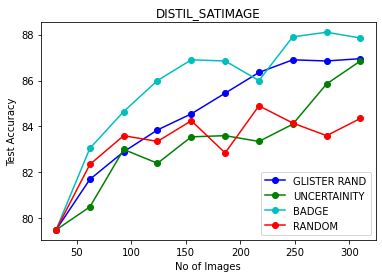

In [27]:
#Loading accuracies
with open(os.path.join(base_dir,'entropy.txt'), 'r') as f:
  acc_ = f.readlines()
acc_en = [round(float(x)*100, 2) for x in acc_]
with open(os.path.join(base_dir,'badge.txt'), 'r') as f:
  acc_ = f.readlines()
acc_bd = [round(float(x)*100, 2) for x in acc_]
with open(os.path.join(base_dir,'glister.txt'), 'r') as f:
  acc_ = f.readlines()
acc_gl = [round(float(x)*100, 2) for x in acc_]
with open(os.path.join(base_dir,'random.txt'), 'r') as f:
  acc_ = f.readlines()
acc_rd = [round(float(x)*100, 2) for x in acc_]

#Plotting
import matplotlib.pyplot as plt
budget = 31 
n_rounds = 10
x_axis = np.array([31+budget*i for i in range(n_rounds)])
plt.figure()
plt.plot(x_axis, acc_gl, 'b-', label='GLISTER RAND',marker='o')
plt.plot(x_axis, acc_en, 'g-', label='UNCERTAINITY',marker='o')
plt.plot(x_axis, acc_bd, 'c', label='BADGE',marker='o')
plt.plot(x_axis, acc_rd, 'r', label='RANDOM',marker='o')


plt.legend()
plt.xlabel('No of Images')
plt.ylabel('Test Accuracy')
plt.title('DISTIL_SATIMAGE')